**Introduction**

Given the goal of improving software development productivity with machine learning methods, software intelligence research has attracted increasing attention in both academia and industries over the last decade. Software code intelligence techniques can help developers reduce tedious repetitive workloads, enhance the programming quality, and improve the overall software development productivity. This would reduce time spent writing software as well as reduce computational and operational costs.

[Text-to-code generation](https://paperswithcode.com/task/text-to-code-generation) is a task where we can generate code based on the natural language description. It can further be used to build an AI-powered coding assistant. Developers simply type the natural language description or the function signature to specify their intents, and the AI coding assistant can generate or complete the target function for them. This helps to accelerate implementation and also reduce their reliance on external resources.

<br>
<center><img src="https://production-media.paperswithcode.com/tasks/code_generation_0P9CcWa.png" alt="code_generation" width="600"/></center>
<br>

[CodeT5 by Salesforce](https://arxiv.org/pdf/2109.00859.pdf) is the first code-aware, encoder-decoder-based pre-trained programming language model, which enables a wide range of code intelligence applications including code understanding and generation tasks. CodeT5 achieves state-of-the-art performance on 14 sub-tasks in the CodeXGLUE code intelligence benchmark.

CodeT5 builds on an encoder-decoder framework with the same architecture as [T5 by Google](https://arxiv.org/pdf/1910.10683.pdf). The T5 model, pre-trained on [C4](https://www.tensorflow.org/datasets/catalog/c4), achieves state-of-the-art results on many NLP benchmarks while being flexible enough to be fine-tuned to a variety of important downstream tasks. T5 architecture employs denoising sequence-to-sequence (Seq2Seq) pre-training and has been shown to benefit out-of-the-box for both understanding and generation tasks in natural language.

In this notebook we will finetune CodeT5 on [MBPP - Mostly Basic Python Problems by Google Research](https://research.google/tools/datasets/mostly-basic-python-problems/) to generate code based on problem description. MBPP is a benchmark that consists of around 1,000 crowd-sourced Python programming problems, designed to be solvable by entry level programmers, covering programming fundamentals, standard library functionality, and so on. Each problem consists of a task description, code solution and 3 automated test cases.

<font color=#425066><b>The notebook demonstrates how to finetune CodeT5 on MBPP Dataset w/ TensorFlow.</b></font>

<style>
a:link {
  color: green;
  background-color: transparent;
  text-decoration: none;
}
</style>

<font color='#FF6F00'><h2>Table of Contents</h2></font>

- [<font color=#FF6F00><b>Introduction</b></font>](#section1)

- [<font color=#FF6F00><b>T5</b></font>](#section2)
  - [<font color=#425066>Explained</font>](#section2a)  
  - [<font color=#425066>Training</font>](#section2b)  
  - [<font color=#425066>Inference</font>](#section2c)  
  - [<font color=#425066>References</font>](#section2d)  
  
- [<font color=#FF6F00><b>CodeT5</b></font>](#section3)
  - [<font color=#425066>Explained</font>](#section3a)  
  - [<font color=#425066>Pretraining</font>](#section3b)  
  - [<font color=#425066>Tokenization</font>](#section3c)  
  - [<font color=#425066>References</font>](#section3d)  
  
- [<font color=#FF6F00><b>Imports</b></font>](#section4)

- [<font color=#FF6F00><b>Setup Strategy</b></font>](#section5)  
  - [<font color=#425066>Mixed Precision Training</font>](#section5a)
  - [<font color=#425066>XLA: Optimizing Compiler for Machine Learning</font>](#section5b)
  - [<font color=#425066>Distributed Training</font>](#section5c)

- [<font color=#FF6F00><b>MBPP Benchmark</b></font>](#section6)
- [<font color=#FF6F00><b>Data Processing</b></font>](#section7)
- [<font color=#FF6F00><b>Utility Functions / Class</b></font>](#section8)
- [<font color=#FF6F00><b>Custom Training Loop</b></font>](#section9)
- [<font color=#FF6F00><b>Run</b></font>](#section10)
- [<font color=#FF6F00><b>Execute</b></font>](#section11)
- [<font color=#FF6F00><b>Predict</b></font>](#section12)
  - [<font color=#425066>Predict from Dataset</font>](#section12a)  
  - [<font color=#425066>Predict from Text</font>](#section12b)
- [<font color=#FF6F00><b>Ending Notes</b></font>](#section13)
- [<font color=#FF6F00><b>References</b></font>](#section14)


<a id="section2"><font color='#FF6F00'><h2>T5</h2></font></a>

<a id="section2a"><font color=#425066><h3>Explained</h3></font></a>

- *T5 — Text-to-Text Transfer Transformer Model* was proposed in the paper, [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683). This paper is essentially a survey of modern transfer learning techniques used in language understanding and hence proposes a unified framework that attempts to combine all language problems into a text-to-text format.

- The text-to-text framework suggests using the same model, same loss function, and the same hyperparameters on all the NLP tasks. In this approach, the inputs are modeled in such a way that the model shall recognize a task, and the output is simply the “text” version of the expected outcome.

<br>
<center><img src="https://miro.medium.com/max/1280/0*xfXDPjASztwmJlOa.gif" alt="t5" width="600"/></center>
<br>

- To avail the same model for all the downstream tasks, a task-specific text prefix is added to the original input that is fed to the model. This text prefix is also considered as a hyperparameter.
> As an example,to ask the model to translate the sentence “That is good.” from English to German, the model would be fed the sequence “translate English to German: That is good.” and would be trained to output “Das ist gut.”
— T5 Paper

 Similarly, for classification tasks, the model predicts a single word corresponding to the target label.
> For example, on the MNLI benchmark the goal is to predict whether a premise implies (“entailment”), contradicts (“contradiction”), or neither (“neutral”) a hypothesis. With our preprocessing, the input sequence becomes “mnli premise: I hate pigeons. hypothesis: My feelings towards pigeons are filled with animosity.” with the corresponding target word “entailment”.
— T5 Paper

- T5 is pretrained using the denoising objective on C4— Colossal Clean Crawled Corpus - a 750GB dataset which is not just reasonably larger than the most pre-training datasets but also contains a relatively very clean text.

<br>
<center><img src="https://miro.medium.com/max/1280/0*8WIzJDlbitZVDGeA.png" alt="t5_pretrain_finetune" width="600"/></center>
<br>

- The proposed model is essentially a Encoder-Decoder [Transformer](https://arxiv.org/abs/1706.03762) with some architectural changes (like applying Layer Normalization before a sub block and then adding the initial input to the sub-block output; also known as pre-norm). Moreover, the model configuration is similar to [BERT base](https://arxiv.org/abs/1810.04805). T5 uses relative scalar embeddings. Encoder input padding can be done on the left and on the right.

- T5 comes in different sizes: t5-small, t5-base, t5-large, t5-3b, t5-11b.

<a id="section2b"><font color=#425066><h3>Training</h3></font></a>

- T5 is an encoder-decoder model and converts all NLP problems into a text-to-text format. It is trained using teacher forcing. This means that for training, we always need an input sequence and a corresponding target sequence. The input sequence is fed to the model using `input_ids`. The target sequence is shifted to the right, i.e., prepended by a start-sequence token and fed to the decoder using the `decoder_input_ids`. In teacher-forcing style, the target sequence is then appended by the EOS token and corresponds to the `labels`. The PAD token is hereby used as the start-sequence token. T5 can be trained / fine-tuned both in a supervised and unsupervised fashion.

- One can use [T5ForConditionalGeneration](https://huggingface.co/docs/transformers/v4.18.0/en/model_doc/t5#transformers.T5ForConditionalGeneration) (or the Tensorflow/Flax variant) from [HuggingFace transformers library](https://huggingface.co/docs/transformers/), which includes the language modeling head on top of the decoder.

- T5 models need a slightly higher learning rate than the default one set in the Trainer when using the AdamW optimizer. Typically, 1e-4 and 3e-4 work well for most problems (classification, summarization, translation, question answering, question generation). Note that T5 was pre-trained using the AdaFactor optimizer.

- Task prefixes matter when (1) doing multi-task training (2) your task is similar or related to one of the supervised tasks used in T5’s pre-training mixture (see Appendix D of the [paper](https://arxiv.org/pdf/1910.10683.pdf) for the task prefixes used).

-  We must make sure that padding token id’s of the labels are not taken into account by the loss function. In PyTorch and Tensorflow, this can be done by replacing them with -100, which is the `ignore_index` of the `CrossEntropyLoss`. We also pass attention_mask as additional input to the model, which makes sure that padding tokens of the inputs are ignored.

<a id="section2c"><font color=#425066><h3>Inference</h3></font></a>

- At inference time, it is recommended to use [generate()](https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate). This method takes care of encoding the input and feeding the encoded hidden states via cross-attention layers to the decoder and auto-regressively generates the decoder output. Check out this [blog post](https://huggingface.co/blog/how-to-generate) to know all the details about generating text with Transformers. There’s also this [blog post](https://huggingface.co/blog/encoder-decoder#encoder-decoder) which explains how generation works in general in encoder-decoder models.

<a id="section2d"><font color=#425066><h3>References</h3></font></a>
- [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683)
- [Google AI Blog - Exploring Transfer Learning with T5: the Text-To-Text Transfer Transformer](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html)
- [HuggingFace - T5](https://huggingface.co/docs/transformers/model_doc/t5#training)
- [Understanding Transformer-Based Self-Supervised Architectures](https://towardsdatascience.com/t5-text-to-text-transfer-transformer-643f89e8905e)
- [T5 - A Detailed Explanation](https://medium.com/analytics-vidhya/t5-a-detailed-explanation-a0ac9bc53e51)


<a id="section3"><font color='#FF6F00'><h2>CodeT5</h2></font></a>

<a id="section3a"><font color=#425066><h3>Explained</h3></font></a>

-  CodeT5 by Salesforce was proposed in [CodeT5: Identifier-aware Unified Pre-trained Encoder-Decoder Models
for Code Understanding and Generation](https://arxiv.org/pdf/2109.00859.pdf) and is an open-source model that can understand and readily generate code. It is an identifier-aware unified pre-trained coder-encoder tool that enables a wide range of code intelligence applications. CodeT5 possesses an uninformed model for natural language processing tasks, which reframes text-to-text with input, and output data always being strings of texts.


- CodeT5 builds on the similar architecture of T5 but incorporates code-specific knowledge to endow the model with better code understanding. It takes code and its accompanying comments as a sequence to build and generate upon. It aims to derive generic representations for programming language (PL) and natural language (NL) via pre-training on unlabeled source code.

- CodeT5 achieves state-of-the-art performance on multiple code-related downstream tasks including understanding tasks such as code defect detection and clone detection, and generation tasks across various directions including PL-NL, NL-PL, and PL-PL.


<a id="section3b"><font color=#425066><h3>Pretraining</h3></font></a>

- CodeT5 was pretrained on the [CodeSearchNet](https://github.com/github/CodeSearchNet) data that consists of both unimodal (PL-only) and bimodal (PL-NL) data on six PLs - `Ruby, JavaScript, Go, Python, PHP, C, and C#`. In addition to that, they further collect extra data of C/C# from open-source Github repositories. They further finetune CodeT5 on most tasks in the [CodeXGLUE benchmark](https://arxiv.org/pdf/2102.04664.pdf), including two understanding tasks: code defect detection and clone detection, and generation tasks such as code summarization, generation, translation, and refinement.

<br>
<center><img src="https://149695847.v2.pressablecdn.com/wp-content/uploads/2021/09/image-179-1024x406.png" alt="codet5_pretraining" width="700"/></center>
<br>

- Some of the pre-training tasks of CodeT5 include:

    - `Masked Span Prediction (MSP)` randomly masks spans with arbitrary lengths and requires the decoder to recover the original input. It captures the syntactic information of the NL-PL input and learns robust cross-lingual representations as we pre-train on multiple PLs with a shared model.
    
    - `Identifier Tagging (IT)` applied only to the encoder which distinguishes whether each code token is an identifier (e.g., variables or function names) or not. It works like the syntax highlighting feature in some developer-aided tools.
    
    - `Masked Identifier Prediction (MIP)`, in contrast to MSP, only masks identifiers and employs the same mask placeholder for all occurrences of one unique identifier. It works like deobfuscation in software engineering and is a more challenging task that requires the model to comprehend the code semantics based on the obfuscated code.
    
    - `Bimodal Dual Generation (dual-gen)` jointly optimizes the conversion from code to its comments and vice versa. It encourages a better alignment between the NL and PL counterparts.
    
<a id="section3c"><font color=#425066><h3>Code-specific Tokenizer</h3></font></a>

- In CodeT5 they train a Byte-level BPE tokenizer and set the vocabulary size to 32,000 as T5. They add additional special tokens ([PAD], [CLS], [SEP], [MASK0], ..., [MASK99]). This tokenzier is trained on all pre-training data with non-printable characters and low-frequent tokens (occurring <3 times) filtered.

- When compared to T5’s default tokenizer they find that the trained tokenizer largely reduces the length of tokenized code sequence by 30% - 45% on downstream tasks. This accelerates the training and especially benefits generation tasks due to the shorter sequence to predict.

- They spot a severe problem for applying the T5’s default tokenizer on source code, where it would encode some common code tokens such as brackets [‘{’, ‘}’] into unknown tokens.

<a id="section3d"><font color=#425066><h3>References</h3></font></a>
- [CodeT5: Identifier-aware Unified Pre-trained Encoder-Decoder Models for Code Understanding and Generation](https://arxiv.org/pdf/2109.00859.pdf)
- [CodeT5 Blog by Salesforce](https://blog.salesforceairesearch.com/codet5/)
- [CodeT5 GitHub Repository](https://github.com/salesforce/CodeT5#fine-tuning)
- [HuggingFace CodeT5-Base Model](https://huggingface.co/Salesforce/codet5-base)
- [Salesforce’s CodeT5 system can understand and generate code](https://venturebeat.com/2021/09/07/salesforces-codet5-system-can-understand-and-generate-code/)
- [Salesforce CodeT5 vs Github Copilot: A Comparative Guide to Auto-code Generators](https://analyticsindiamag.com/salesforce-codet5-vs-github-copilot-a-comparative-guide-to-auto-code-generators/)
- [Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/T5/Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code.ipynb)
- [CodeXGLUE: A Machine Learning Benchmark Dataset for Code Understanding and Generation](https://arxiv.org/pdf/2102.04664.pdf)
- [CodeSearchNet](https://github.com/github/CodeSearchNet)
- [OpenAI Codex](https://openai.com/blog/openai-codex/)

<a id="section4"><font color='#FF6F00'><h2>Imports</h2></font></a>

Let's start by importing required libraries to the environment:

- [*TensorFlow*](https://www.tensorflow.org/) an end-to-end open source platform for machine learning.
- [*transformers*](https://huggingface.co/docs/transformers/index) provides APIs to easily download and train state-of-the-art pretrained models
- [*datasets*](https://huggingface.co/docs/datasets/index) a library for easily accessing and sharing datasets.

In [1]:
!cp "../input/tf-custom-training-loop-figure/tf_process.png" "../working/"

cp: cannot stat '../input/tf-custom-training-loop-figure/tf_process.png': No such file or directory


In [2]:
pip install transformers

In [3]:
import os
import time
import math
import random
import datetime
from pathlib import Path

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # reduce the amount of console output from TF
import tensorflow as tf

from transformers import *
!pip install -q datasets # install HF datasets library
from datasets import load_dataset

logging.set_verbosity_warning()
logging.set_verbosity_error()

import logging

print('TF version',tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # check GPU available

🚨 Config not found for parakeet. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py
🚨 Config not found for parakeet. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py
🚨 Config not found for parakeet. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py


TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


TF version 2.19.0
Num GPUs Available:  1


<a id="section5"><font color='#FF6F00'><h2>Setup Strategy</h2></font></a>

<a id="section5a"><font color=#425066><h3>Mixed Precision Training</h3></font></a>

- Floating point types store numeric information of three types – the sign, exponent, and fraction.  Traditional float32 representations have 8 bits and 23 bits respectively to represent the exponent and fraction.  Traditional float16 representations (the format used for NVIDIA hardware) roughly halve both the exponent and fraction components of the representation. TPUs use a variant called bfloat16.

- Most of a transformer network can be naively converted to float16 weights and activations with no accuracy penalty.

<br>
<center><img src="https://www.pragmatic.ml/content/images/2020/04/image-2.png" alt="fp16" width="600"/></center>
<br>

- Small portions of the network – in particular, portions of the softmax operation – must remain in float32.  This is because the sum of a large number of small values (our logits) can be a source of accumulated error. Because both float16 and float32 values are used, this method is often referred to as "mixed-precision" training.
  
- Less precise numeric representations enable speedups from two sources.
 - Native half-precision instructions
 - Larger batch sizes thanks to more compact representations

- Note:
   > While mixed precision will run on most hardware, it will only speed up models on recent NVIDIA GPUs and Cloud TPUs. NVIDIA GPUs support using a mix of float16 and float32, while TPUs support a mix of bfloat16 and float32. Among NVIDIA GPUs, those with compute capability 7.0 or higher will see the greatest performance benefit from mixed precision because they have special hardware units, called Tensor Cores, to accelerate float16 matrix multiplications and convolutions. - TensorFlow
   
<a id="section5b"><font color=#425066><h3>XLA: Optimizing Compiler for Machine Learning</h3></font></a>

- XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that can accelerate TensorFlow models with potentially no source code changes.

<br>
<center><img src="https://www.tensorflow.org/xla/images/tf_xla_performance.png" alt="xla" width="500" height="500"/></center>
<br>

- When a TensorFlow program is run, all of the operations are executed individually by the TensorFlow executor. Each TensorFlow operation has a precompiled GPU kernel implementation that the executor dispatches to. XLA provides an alternative mode of running models: it compiles the TensorFlow graph into a sequence of computation kernels generated specifically for the given model. Because these kernels are unique to the model, they can exploit model-specific information for optimization. For example, let's look at an optimization XLA does in the context of a simple TensorFlow computation:

    ```
    def model_fn(x, y, z):
      return tf.reduce_sum(x + y * z)
    ```

- XLA can optimize the graph so that it computes the result in a single kernel launch. It does this by "fusing" the addition, multiplication and reduction into a single GPU kernel. Moreover, this fused operation does not write out the intermediate values produced by y*z and x+y*z to memory; instead it "streams" the results of these intermediate computations directly to their users while keeping them entirely in GPU registers. Fusion is XLA's single most important optimization.

<a id="section5c"><font color=#425066><h3>Distribution Strategy</h3></font></a>
- `tf.distribute.Strategy` is a TensorFlow API to distribute training across multiple GPUs, multiple machines, or TPUs. Using this API, we can distribute our existing models and training code with minimal code changes.

- `tf.distribute.Strategy` intends to cover a number of use cases along different axes. Some of these axes are:

    - Synchronous vs asynchronous training: These are two common ways of distributing training with data parallelism. In sync training, all workers train over different slices of input data in sync, and aggregating gradients at each step. In async training, all workers are independently training over the input data and updating variables asynchronously. Typically sync training is supported via all-reduce and async through parameter server architecture.
    - Hardware platform: You may want to scale your training onto multiple GPUs on one machine, or multiple machines in a network (with 0 or more GPUs each), or on Cloud TPUs.
    
- We can use `tf.distribute.Strategy` with very few changes to our code, because the underlying components of TensorFlow have been changed to become strategy-aware. This includes variables, layers, models, optimizers, metrics, summaries, and checkpoints.

- We can execute our programs eagerly, or in a graph using `tf.function`. It intends to support both these modes of execution, but works best with graph execution.

- The `tf.distribute.Strategy` classes provide a core set of methods to support custom training loops. Using these may require minor restructuring of the code initially, but once that is done, we should be able to switch between GPUs, TPUs, and multiple machines simply by changing the strategy instance.

- *Note*: For single GPU we have `tf.distribute.OneDeviceStrategy`. This is a strategy to place all variables and computation on a single specified device.
 > This strategy is distinct from the Default Strategy in a number of ways. In the Default Strategy, the variable placement logic remains unchanged when compared to running TensorFlow without any distribution strategy. But when using OneDeviceStrategy, all variables created in its scope are explicitly placed on the specified device. Moreover, any functions called via OneDeviceStrategy.run will also be placed on the specified device. Input distributed through this strategy will be prefetched to the specified device. In the Default Strategy, there is no input distribution.

In [4]:
def setup_strategy(xla, fp16, no_cuda):
    print(" Tensorflow: setting up strategy")

    # setup xla
    if xla:
        print(" XLA Enabled")
        tf.config.optimizer.set_jit(True)

    # setup mixed precision training
    if fp16:
        # Set to float16 at first
        print(" Mixed Precision Training Enabled")
        policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
        tf.keras.mixed_precision.experimental.set_policy(policy)

    # setup distribution strategy
    gpus = tf.config.list_physical_devices("GPU")
    if no_cuda:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
    else:
        if len(gpus) == 0:
            print(" One Device Strategy [CPU] Enabled")
            strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
        elif len(gpus) == 1:
            print(" One Device Strategy [GPU] Enabled")
            strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        elif len(gpus) > 1:
            print(" Mirrored Strategy Enabled")
            # If only want to use a specific subset of GPUs use CUDA_VISIBLE_DEVICES=0`
            strategy = tf.distribute.MirroredStrategy()
        else:
            strategy = tf.distribute.get_strategy()

    return strategy

def n_replicas(strategy):
    # return number of devices
    return strategy.num_replicas_in_sync

# note:
# huggingface TF-T5 implementation has issues when mixed precision is enabled
# we will disable FP16 for this but can be used for training any other model
strategy = setup_strategy(xla=True, fp16=False, no_cuda=False)

 Tensorflow: setting up strategy
 XLA Enabled
 One Device Strategy [GPU] Enabled


<a id="section6"><font color='#FF6F00'><h2>MBPP (Mostly Basic Python Problems) Benchmark</h2></font></a>

- The Mostly Basic Programming Problems dataset was introduced in [Program Synthesis with Large Language Models](https://arxiv.org/pdf/2108.07732.pdf). It contains 974 short Python functions designed to be solved by entry-level programmers, text descriptions of those programs, and test cases to check for functional correctness. This dataset consists of a large set of crowd-sourced questions and a smaller set of questions edited and hand verified by the authors.


- The problems range from simple numeric manipulations or tasks that require basic usage of standard library functions to tasks that require nontrivial external knowledge, such as the definition of particular notable integer sequences.

- Given this, they manually inspected, edited, and pruned a subset of the questions, yielding 426 hand-verified questions, which we refer to as the edited dataset. For each question in the edited dataset, they ensured it had a standard Python function signature, that it was unambiguous to a human, and that its test cases accurately reflected the text description.

- The original and cleaned dataset is available [here](https://github.com/google-research/google-research/tree/master/mbpp).

<a id="section7"><font color='#FF6F00'><h2>Dataset Processing</h2></font></a>

Below is the complete process from data downloading to processing and converting to TensorFlow `tf.data.Dataset` object. It gives an overview of our data loading pipeline but to have a comprehensive idea one can read about tf.Data API [here](https://www.tensorflow.org/guide/data) and how to optimize data pipeline performance [here](https://www.tensorflow.org/guide/data_performance)

*Note: check `run()` method for complete code flow.*

- `download_dataset()` downloads the mbpp dataset from url and we load using hf datasets `load_dataset()` function.
- `convert_examples_to_features()` creates features (input_ids, attention_mask, labels) required for our model training using `map()` function.
- split the training data into train/test with test_size of size 0.1% of total training data using `split()` method.
- `get_train_tfdataset()` and `get_validation_tfdataset()`converts the dataset to tensorflow tf.data.Dataset object.

    - The `Dataset.from_generator` constructor converts the python generator to a fully functional `tf.data.Dataset`. The constructor takes a callable as input, not an iterator. This allows it to restart the generator when it reaches the end. The `output_types` argument is required because `tf.data` builds a `tf.Graph` internally, and graph edges require a `tf.dtype`. It's also important to note that the `output_shapes` and `output_types` follow the same nesting rules as other dataset methods.
    
    - The simplest way to iterate over a dataset in multiple epochs is to use the `Dataset.repeat()` transformation. Applying the `Dataset.repeat()` transformation with no arguments will repeat the input indefinitely.
    - The `Dataset.shuffle()` transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer. We apply `Dataset.shuffle()` only for training dataset and not for validation dataset.
    - A `Dataset.batch` applied after `Dataset.repeat` will yield batches that straddle epoch boundaries. If you need clear epoch separation, put `Dataset.batch` before the repeat.
    - Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step `s`, the input pipeline is reading the data for step `s+1`. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data. The `tf.data` API provides the `tf.data.Dataset.prefetch` transformation. It can be used to decouple the time when data is produced from the time when data is consumed. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to `tf.data.AUTOTUNE`, which will prompt the `tf.data` runtime to tune the value dynamically at runtime.

In [5]:
def download_dataset(cache_dir):
    # download data using a keras utility
    _url = "https://raw.githubusercontent.com/google-research/google-research/master/mbpp/mbpp.jsonl" # download mbpp dataset
    dataset_path = tf.keras.utils.get_file("mbpp.jsonl", origin=_url, cache_dir=cache_dir, cache_subdir=cache_dir)
    return dataset_path

def convert_examples_to_features(examples, tokenizer, args):
    # encode text-code pairs
    texts = examples['text']
    codes = examples['code']
    # tests = [" ".join(test) for test in examples['test_list']] # convert list of test cases to single string

    # encode texts by prepending the task for input sequence
    inputs = [args.prefix + text for text in texts]
    model_inputs = tokenizer(inputs, max_length=args.max_input_length, padding="max_length", truncation=True)

    # encode texts by prepending the task for input sequence and appending the test sequence
    # inputs = [args.prefix + text + " " + test for text, test in zip(texts, tests)]
    # model_inputs = tokenizer(inputs, max_length=args.max_input_length, padding="max_length", truncation=True)

    # encode texts by prepending the task for input sequence
    labels = tokenizer(codes, max_length=args.max_target_length, padding="max_length", truncation=True).input_ids

    # we need to replace the index of the padding tokens by -100
    # such that they are not taken into account by the CrossEntropyLoss
    labels_with_ignore_index = []
    for labels_example in labels:
        labels_example = [label if label != 0 else -100 for label in labels_example]
        labels_with_ignore_index.append(labels_example)
    model_inputs["labels"] = labels_with_ignore_index

    # return features
    return model_inputs


def get_train_tfdataset(train_dataset, num_train_examples, args):
    # select feature columns
    columns = ['input_ids', 'attention_mask', 'labels']
    # set to tensorflow format
    train_dataset.set_format(type='tensorflow', columns=columns)

    # specify return types
    return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 'labels':tf.int32}
    # specify return shapes
    return_shapes = {'input_ids': tf.TensorShape([None]),'attention_mask': tf.TensorShape([None]), 'labels': tf.TensorShape([None])}
    # initialize dataset
    tf_dataset = tf.data.Dataset.from_generator(lambda : train_dataset, return_types, return_shapes)

    # turn off auto-sharding
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    tf_dataset = tf_dataset.with_options(options)

    # repeat, shuffle, batch, prefetch
    ds = (
        tf_dataset.repeat()
        .shuffle(num_train_examples, seed=args.seed)
        .batch(args.train_batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # distribute dataset to devices
    return strategy.experimental_distribute_dataset(ds)

def get_validation_tfdataset(eval_dataset, num_validation_examples, args):
    # select feature columns
    columns = ['input_ids', 'attention_mask', 'labels']
    # set to tensorflow format
    eval_dataset.set_format(type='tensorflow', columns=columns)

    # specify return types
    return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 'labels':tf.int32}
    # specify return shapes
    return_shapes = {'input_ids': tf.TensorShape([None]),'attention_mask': tf.TensorShape([None]), 'labels': tf.TensorShape([None])}
    # initialize dataset
    tf_dataset = tf.data.Dataset.from_generator(lambda : eval_dataset, return_types, return_shapes)

    # turn off auto-sharding
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    tf_dataset = tf_dataset.with_options(options)

    # repeat, batch, prefetch
    ds = (
        tf_dataset.repeat()
        .batch(args.validation_batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # distribute dataset to devices
    return strategy.experimental_distribute_dataset(ds)

<a id="section8"><font color='#FF6F00'><h2>Utility Functions / Class</h2></font></a>

- *fix_all_seeds()* - sets the random seed for deterministic results.
- *init_logger()* - initialize logger for tracking events.
- *ProgressBar()* - custom progress bar to display metrics.

In [6]:
def fix_all_seeds(seed):
    # set random seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def init_logger(log_file=None, log_file_level=logging.NOTSET):
    # initialize logger for tracking events and save in file
    if isinstance(log_file, Path):
        log_file = str(log_file)
    log_format = logging.Formatter(
        fmt='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S'
    )
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(log_format)
    logger.handlers = [console_handler]
    if log_file and log_file != '':
        file_handler = logging.FileHandler(log_file)
        file_handler.setLevel(log_file_level)
        # file_handler.setFormatter(log_format)
        logger.addHandler(file_handler)
    return logger

class ProgressBar(object):
    # custom progress bar
    def __init__(self, n_total,width=30,desc = 'Training'):
        self.width = width
        self.n_total = n_total
        self.start_time = time.time()
        self.desc = desc

    def __call__(self, step, info={}):
        now = time.time()
        current = step + 1
        recv_per = current / self.n_total
        bar = f'[{self.desc}] {current}/{self.n_total} ['
        if recv_per >= 1:
            recv_per = 1
        prog_width = int(self.width * recv_per)
        if prog_width > 0:
            bar += '=' * (prog_width - 1)
            if current< self.n_total:
                bar += ">"
            else:
                bar += '='
        bar += '.' * (self.width - prog_width)
        bar += ']'
        show_bar = f"\r{bar}"
        time_per_unit = (now - self.start_time) / current
        if current < self.n_total:
            eta = time_per_unit * (self.n_total - current)
            if eta > 3600:
                eta_format = ('%d:%02d:%02d' %
                              (eta // 3600, (eta % 3600) // 60, eta % 60))
            elif eta > 60:
                eta_format = '%d:%02d' % (eta // 60, eta % 60)
            else:
                eta_format = '%ds' % eta
            time_info = f' - ETA: {eta_format}'
        else:
            if time_per_unit >= 1:
                time_info = f' {time_per_unit:.1f}s/step'
            elif time_per_unit >= 1e-3:
                time_info = f' {time_per_unit * 1e3:.1f}ms/step'
            else:
                time_info = f' {time_per_unit * 1e6:.1f}us/step'

        show_bar += time_info
        if len(info) != 0:
            show_info = f'{show_bar} ' + \
                        "-".join([f' {key}: {value:.4f} ' if key != "learning_rate" else f' {key}: {value:.8f} ' for key, value in info.items()])
            print(show_info, end='')
        else:
            print(show_bar, end='')

<a id="section9"><font color='#FF6F00'><h2>Custom Training Loop</h2></font></a>

Here we define our Trainer class for training and evaluation loop. Custom training loops provide flexibility and a greater control on training. They also make it is easier to debug the model and the training loop. The following code block sets up these training steps:

1. Iterate each epoch. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training Dataset grabbing its features (x) and label (y).
3. Using the features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an optimizer to update the model's parameters.
5. Keep track of some stats for logging.
6. Repeat for each epoch.

Below figure demonstrates the code flow of our `trainer.train()` method. One can read about Custom Training Loops [here](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough) and [here](https://www.tensorflow.org/tutorials/distribute/custom_training).


*Notes:*
- Iterate over the `train_dist_dataset` and `test_dist_dataset` using a for `x in ...` construct.

- model, optimizer, and checkpoint must be created under `strategy.scope`.

- `strategy.run()` replicates the provided computation and runs it with the distributed input. It returns results from each local replica in the strategy, and there are multiple ways to consume this result.

- A model checkpointed with a `tf.distribute.Strategy` can be restored with or without a strategy.

- `tf.function` helps to make graphs out of your programs. It is a transformation tool that creates Python-independent dataflow graphs out of your Python code. This will help you create performant and portable models, and it is required to use SavedModel. One can read more about `tf.function` [here](https://www.tensorflow.org/guide/function).

- Using `tf.reduce_mean` is not recommended. Doing so divides the loss by actual per replica batch size which may vary step to step.

In [7]:
class Trainer:
    def __init__(
        self, model, args, train_dataset, validation_dataset,
        num_train_examples, num_validation_examples
    ):
        self.model = model
        self.args = args

        self.train_dataset = train_dataset
        self.num_train_examples = num_train_examples

        self.validation_dataset = validation_dataset
        self.num_validation_examples = num_validation_examples

        self.global_step = 0
        self.eval_loss = tf.keras.metrics.Sum()

    def create_optimizer_and_scheduler(self, num_training_steps):
        # creates an optimizer with a learning rate schedule using a warmup phase followed by a linear decay.
        num_warmup_steps = math.ceil(num_training_steps * self.args.warmup_ratio)
        self.optimizer, self.lr_scheduler = create_optimizer(
            init_lr=self.args.learning_rate,
            num_train_steps=num_training_steps,
            num_warmup_steps=num_warmup_steps,
            weight_decay_rate=self.args.weight_decay,
            adam_epsilon=self.args.adam_epsilon
        )

    def evaluation_step(self, features, labels, nb_instances_in_global_batch):
        # forward pass
        outputs = self.model(input_ids=features['input_ids'], attention_mask=features['attention_mask'], labels=labels, training=False)[:2]
        loss, logits = outputs[:2]
        # loss scaling
        scaled_loss = loss / tf.cast(nb_instances_in_global_batch, dtype=loss.dtype)
        # add current batch loss
        self.eval_loss.update_state(scaled_loss)

    @tf.function
    def distributed_evaluation_steps(self, batch):
        features = {k: v for k, v in batch.items() if 'labels' not in k}
        labels = batch['labels']
        nb_instances = tf.reduce_sum(tf.cast(labels != -100, dtype=tf.int32))
        # strategy.run() expects args to be a list or tuple
        inputs = (features, labels, nb_instances)
        # `run` replicates the provided computation and runs with the distributed input
        strategy.run(self.evaluation_step, inputs)

    def evaluate(self):
        # calculate total validation steps
        steps = math.ceil(self.num_validation_examples / self.args.validation_batch_size)
        # reset eval loss after every epoch
        self.eval_loss.reset_states()
        logs = {}
        pbar = ProgressBar(n_total=steps, desc='Evaluating')
        # iterate over validation dataset
        for step, batch in enumerate(self.validation_dataset):
            # distributed evaluation step
            self.distributed_evaluation_steps(batch)
            logs["eval_loss"] = self.eval_loss.result() / (step + 1)
            pbar(step=step, info=logs)
            if step == steps - 1:
                break
        print("\n------------- validation result -----------------")

    def apply_gradients(self, features, labels, nb_instances_in_global_batch):
        # forward pass
        outputs = self.model(input_ids=features['input_ids'], attention_mask=features['attention_mask'], labels=labels, training=True)[:2]
        loss, logits = outputs[:2]
        # loss scaling
        scaled_loss = loss / tf.cast(nb_instances_in_global_batch, dtype=loss.dtype)
        # calculate gradients
        gradients = tf.gradients(scaled_loss, self.model.trainable_variables)
        # convert gradients with nan value
        gradients = [g if g is not None else tf.zeros_like(v) for g, v in zip(gradients, self.model.trainable_variables)]
        # optimize the model
        self.optimizer.apply_gradients(list(zip(gradients, self.model.trainable_variables)))
        # add current batch loss
        self.train_loss.update_state(scaled_loss)

    @tf.function
    def distributed_training_steps(self, batch):
        with strategy.scope():
            features = {k: v for k, v in batch.items() if 'labels' not in k}
            labels = batch['labels']
            nb_instances = tf.reduce_sum(tf.cast(labels != -100, dtype=tf.int32))
            # strategy.run() expects args to be a list or tuple
            inputs = (features, labels, nb_instances)
            # `run` replicates the provided computation and runs with the distributed input.
            strategy.run(self.apply_gradients, inputs)

    def train(self):
        # calculate total training steps
        num_updates_per_epoch = self.num_train_examples // args.train_batch_size
        self.steps_per_epoch = num_updates_per_epoch
        t_total = self.steps_per_epoch * self.args.epochs

        with strategy.scope():
            # optimizer, and checkpoint must be created under `strategy.scope`
            # create optimizer and scheduler
            self.create_optimizer_and_scheduler(num_training_steps=t_total)

            # create checkpoint manager
            folder = os.path.join(self.args.output_dir, self.args.checkpoint_dir)
            ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
            self.model.ckpt_manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
            iterations = self.optimizer.iterations

            logger.info("***** Running training *****")
            logger.info(f"  Num examples = {self.num_train_examples}")
            logger.info(f"  Num Epochs = {self.args.epochs}")
            logger.info(f"  Total train batch size (w. parallel & distributed) = {self.args.train_batch_size * n_replicas(strategy)}")
            logger.info(f"  Steps per epoch = {self.steps_per_epoch}")
            logger.info(f"  Total optimization steps = {t_total}")

            self.train_loss = tf.keras.metrics.Sum(name="training_loss")
            start_time = datetime.datetime.now()
            for epoch_iter in range(self.args.epochs):
                # training loop
                logger.info(f"Epoch {epoch_iter + 1}/{self.args.epochs}")

                pbar = ProgressBar(n_total=self.steps_per_epoch, desc='Training')
                # iterate over training dataset
                for step, batch in enumerate(self.train_dataset):
                    # distributed training step
                    self.distributed_training_steps(batch)

                    self.global_step = iterations.numpy()
                    training_loss = self.train_loss.result() / (step + 1)

                    logs = {}
                    logs["training_loss"] = training_loss.numpy()
                    logs["learning_rate"] = self.lr_scheduler(self.global_step).numpy()
                    pbar(step=step, info=logs)

                    if self.global_step % self.steps_per_epoch == 0:
                        print("\n------------- train result -----------------")
                        # call to evaluation loop
                        self.evaluate()
                        # save checkpoint
                        ckpt_save_path = self.model.ckpt_manager.save()
                        logger.info(f"Saving checkpoint at {ckpt_save_path}")
                        break

                # reset train loss after every epoch
                self.train_loss.reset_states()
            end_time = datetime.datetime.now()
            logger.info(f"Training took: {str(end_time - start_time)}")

<a id="section10"><font color='#FF6F00'><h2>Run</h2></font></a>

The `run()` function defines our execution process. We download, load and preprocess and convert our data into `tf.data.Dataset` format. We initialize tokenizer and model. The model needs to be created under `strategy.scope()`. We create instance of our `Trainer` and pass everything to `.train()` method for running our custom training loop. In the end we save our model and tokenizer using `.save_pretrained()` method.

In [8]:
def run(args):
    logger.info(" Starting training / evaluation")

    logger.info(" Downloading Data Files")
    dataset_path = download_dataset(args.cache_dir)

    logger.info(" Loading Data Files")
    dataset = load_dataset('json', data_files=dataset_path)
    # train test split
    dataset = dataset['train'].train_test_split(0.1, shuffle=False)

    logger.info(" Initializing Tokenizer")
    tokenizer = RobertaTokenizer.from_pretrained(args.tokenizer_name)

    logger.info(" Preparing Features")
    dataset = dataset.map(convert_examples_to_features, batched=True, fn_kwargs={"tokenizer":tokenizer, "args":args})

    logger.info(" Intializing training and validation dataset ")
    train_dataset = dataset['train']
    num_train_examples = len(dataset['train'])
    # create tf train dataset
    tf_train_dataset = get_train_tfdataset(train_dataset, num_train_examples, args)

    validation_dataset = dataset['test']
    num_validation_examples = len(dataset['test'])
    # create tf validation dataset
    tf_validation_dataset = get_validation_tfdataset(train_dataset, num_validation_examples, args)

    logger.info(f' Intializing model | {args.model_type.upper()} ')
    with strategy.scope():
        # model must be created under `strategy.scope`
        model = TFT5ForConditionalGeneration.from_pretrained(args.model_name_or_path, from_pt=True)

    # custom training loop
    trainer = Trainer(model, args, tf_train_dataset, tf_validation_dataset, num_train_examples, num_validation_examples)
    trainer.train()

    # save pretrained model and tokenizer
    logger.info(f" Saving model in {args.save_dir}")
    trainer.model.save_pretrained(args.save_dir)
    tokenizer.save_pretrained(args.save_dir)

<a id="section11"><font color='#FF6F00'><h2>Execute</h2></font></a>

Below we define our training arguments - model, data, optimizer, training and initialize directories. Initialize logger for logging and tracking metrics. We call `fix_all_seeds()` to set the global seed. Then finally we execute our `run()` method by passing our training `args`.

In [9]:
class Args:
    # define training arguments

    # MODEL
    model_type = 't5'
    tokenizer_name = 'Salesforce/codet5-base'
    model_name_or_path = 'Salesforce/codet5-base'

    # DATA
    train_batch_size = 8
    validation_batch_size = 8
    max_input_length = 48
    max_target_length = 128
    prefix = "Generate Python: "

    # OPTIMIZER
    learning_rate = 3e-4
    weight_decay = 1e-4
    warmup_ratio = 0.2
    adam_epsilon = 1e-8

    # TRAINING
    seed = 2022
    epochs = 20

    # DIRECTORIES
    output_dir = "runs/"
    logging_dir = f"{output_dir}/logs/"
    checkpoint_dir = f"checkpoint"
    save_dir = f"{output_dir}/saved_model/"
    cache_dir = '../working/'
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    Path(logging_dir).mkdir(parents=True, exist_ok=True)
    Path(save_dir).mkdir(parents=True, exist_ok=True)


# initialize training arguments
args = Args()
# initialize logger
logger = init_logger(log_file=os.path.join(args.logging_dir, f"{args.model_type}-{time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())}.log"))
# fix all seeds
fix_all_seeds(args.seed)

if __name__ == "__main__":
    # run training and evaluation
    dataset = run(args)

10/29/2025 18:15:45 - INFO - root -    Starting training / evaluation
10/29/2025 18:15:45 - INFO - root -    Downloading Data Files


563743/563743 [==============================] - 0s 0us/step


10/29/2025 18:15:45 - INFO - root -    Loading Data Files


Generating train split: 0 examples [00:00, ? examples/s]

10/29/2025 18:15:46 - INFO - root -    Initializing Tokenizer
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

10/29/2025 18:15:47 - INFO - root -    Preparing Features


Map:   0%|          | 0/876 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

10/29/2025 18:15:50 - INFO - root -    Intializing training and validation dataset 
10/29/2025 18:15:52 - INFO - root -    Intializing model | T5 


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

10/29/2025 18:16:06 - INFO - root -   ***** Running training *****
10/29/2025 18:16:06 - INFO - root -     Num examples = 876
10/29/2025 18:16:06 - INFO - root -     Num Epochs = 20
10/29/2025 18:16:06 - INFO - root -     Total train batch size (w. parallel & distributed) = 8
10/29/2025 18:16:06 - INFO - root -     Steps per epoch = 109
10/29/2025 18:16:06 - INFO - root -     Total optimization steps = 2180
10/29/2025 18:16:06 - INFO - root -   Epoch 1/20


[Training] 109/109 [==============================] 835.1ms/step  training_loss: 0.0071 - learning_rate: 0.00007500 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 678.5ms/step  eval_loss: 0.0030 
------------- validation result -----------------


10/29/2025 18:17:48 - INFO - absl -   Sharding callback duration: 1389 microseconds
10/29/2025 18:18:11 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-1
10/29/2025 18:18:28 - INFO - root -   Epoch 2/20


[Training] 109/109 [==============================] 385.4ms/step  training_loss: 0.0029 - learning_rate: 0.00015000 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 118.7ms/step  eval_loss: 0.0021 
------------- validation result -----------------


10/29/2025 18:19:14 - INFO - absl -   Sharding callback duration: 402 microseconds
10/29/2025 18:21:21 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-2
10/29/2025 18:21:21 - INFO - root -   Epoch 3/20


[Training] 109/109 [==============================] 391.9ms/step  training_loss: 0.0023 - learning_rate: 0.00022500 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 121.2ms/step  eval_loss: 0.0016 
------------- validation result -----------------


10/29/2025 18:22:07 - INFO - absl -   Sharding callback duration: 697 microseconds
10/29/2025 18:23:50 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-3
10/29/2025 18:23:50 - INFO - root -   Epoch 4/20


[Training] 109/109 [==============================] 391.2ms/step  training_loss: 0.0020 - learning_rate: 0.00030000 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 119.8ms/step  eval_loss: 0.0013 
------------- validation result -----------------


10/29/2025 18:24:37 - INFO - absl -   Sharding callback duration: 373 microseconds
10/29/2025 18:26:16 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-4
10/29/2025 18:26:16 - INFO - root -   Epoch 5/20


[Training] 109/109 [==============================] 389.1ms/step  training_loss: 0.0016 - learning_rate: 0.00028125 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 119.9ms/step  eval_loss: 0.0010 
------------- validation result -----------------


10/29/2025 18:27:02 - INFO - absl -   Sharding callback duration: 2144 microseconds
10/29/2025 18:28:51 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-5
10/29/2025 18:28:51 - INFO - root -   Epoch 6/20


[Training] 109/109 [==============================] 387.7ms/step  training_loss: 0.0013 - learning_rate: 0.00026250 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 126.2ms/step  eval_loss: 0.0007 
------------- validation result -----------------


10/29/2025 18:29:37 - INFO - absl -   Sharding callback duration: 329 microseconds
10/29/2025 18:31:19 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-6
10/29/2025 18:31:19 - INFO - root -   Epoch 7/20


[Training] 109/109 [==============================] 387.2ms/step  training_loss: 0.0010 - learning_rate: 0.00024375 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 118.4ms/step  eval_loss: 0.0005 
------------- validation result -----------------


10/29/2025 18:32:04 - INFO - absl -   Sharding callback duration: 539 microseconds
10/29/2025 18:34:19 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-7
10/29/2025 18:34:19 - INFO - root -   Epoch 8/20


[Training] 109/109 [==============================] 389.3ms/step  training_loss: 0.0008 - learning_rate: 0.00022500 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 119.7ms/step  eval_loss: 0.0004 
------------- validation result -----------------


10/29/2025 18:35:06 - INFO - absl -   Sharding callback duration: 334 microseconds
10/29/2025 18:36:53 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-8
10/29/2025 18:36:53 - INFO - root -   Epoch 9/20


[Training] 109/109 [==============================] 393.1ms/step  training_loss: 0.0006 - learning_rate: 0.00020625 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 118.7ms/step  eval_loss: 0.0002 
------------- validation result -----------------


10/29/2025 18:37:39 - INFO - absl -   Sharding callback duration: 259 microseconds
10/29/2025 18:38:29 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-9
10/29/2025 18:38:29 - INFO - root -   Epoch 10/20


[Training] 109/109 [==============================] 387.0ms/step  training_loss: 0.0005 - learning_rate: 0.00018750 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 121.4ms/step  eval_loss: 0.0001 
------------- validation result -----------------


10/29/2025 18:39:16 - INFO - absl -   Sharding callback duration: 310 microseconds
10/29/2025 18:40:02 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-10
10/29/2025 18:40:02 - INFO - root -   Epoch 11/20


[Training] 109/109 [==============================] 388.4ms/step  training_loss: 0.0004 - learning_rate: 0.00016875 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 120.1ms/step  eval_loss: 0.0001 
------------- validation result -----------------


10/29/2025 18:40:48 - INFO - absl -   Sharding callback duration: 1258 microseconds
10/29/2025 18:41:20 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-11
10/29/2025 18:41:20 - INFO - root -   Epoch 12/20


[Training] 109/109 [==============================] 388.5ms/step  training_loss: 0.0003 - learning_rate: 0.00015000 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 120.2ms/step  eval_loss: 0.0001 
------------- validation result -----------------


10/29/2025 18:42:07 - INFO - absl -   Sharding callback duration: 307 microseconds
10/29/2025 18:43:03 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-12
10/29/2025 18:43:03 - INFO - root -   Epoch 13/20


[Training] 109/109 [==============================] 388.8ms/step  training_loss: 0.0002 - learning_rate: 0.00013125 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 120.7ms/step  eval_loss: 0.0001 
------------- validation result -----------------


10/29/2025 18:43:49 - INFO - absl -   Sharding callback duration: 287 microseconds
10/29/2025 18:44:39 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-13
10/29/2025 18:44:39 - INFO - root -   Epoch 14/20


[Training] 109/109 [==============================] 386.9ms/step  training_loss: 0.0002 - learning_rate: 0.00011250 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 120.5ms/step  eval_loss: 0.0000 
------------- validation result -----------------


10/29/2025 18:45:26 - INFO - absl -   Sharding callback duration: 591 microseconds
10/29/2025 18:46:29 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-14
10/29/2025 18:46:29 - INFO - root -   Epoch 15/20


[Training] 109/109 [==============================] 388.1ms/step  training_loss: 0.0002 - learning_rate: 0.00009375 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 118.6ms/step  eval_loss: 0.0000 
------------- validation result -----------------


10/29/2025 18:47:15 - INFO - absl -   Sharding callback duration: 309 microseconds
10/29/2025 18:47:53 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-15
10/29/2025 18:47:53 - INFO - root -   Epoch 16/20


[Training] 109/109 [==============================] 387.2ms/step  training_loss: 0.0001 - learning_rate: 0.00007500 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 121.3ms/step  eval_loss: 0.0000 
------------- validation result -----------------


10/29/2025 18:48:38 - INFO - absl -   Sharding callback duration: 388 microseconds
10/29/2025 18:49:25 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-16
10/29/2025 18:49:25 - INFO - root -   Epoch 17/20


[Training] 109/109 [==============================] 389.4ms/step  training_loss: 0.0001 - learning_rate: 0.00005625 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 120.2ms/step  eval_loss: 0.0000 
------------- validation result -----------------


10/29/2025 18:50:12 - INFO - absl -   Sharding callback duration: 1777 microseconds
10/29/2025 18:50:59 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-17
10/29/2025 18:50:59 - INFO - root -   Epoch 18/20


[Training] 109/109 [==============================] 392.6ms/step  training_loss: 0.0001 - learning_rate: 0.00003750 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 121.7ms/step  eval_loss: 0.0000 
------------- validation result -----------------


10/29/2025 18:51:45 - INFO - absl -   Sharding callback duration: 1753 microseconds
10/29/2025 18:52:31 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-18
10/29/2025 18:52:31 - INFO - root -   Epoch 19/20


[Training] 109/109 [==============================] 391.9ms/step  training_loss: 0.0001 - learning_rate: 0.00001875 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 120.9ms/step  eval_loss: 0.0000 
------------- validation result -----------------


10/29/2025 18:53:19 - INFO - absl -   Sharding callback duration: 419 microseconds
10/29/2025 18:54:16 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-19
10/29/2025 18:54:16 - INFO - root -   Epoch 20/20


[Training] 109/109 [==============================] 390.4ms/step  training_loss: 0.0001 - learning_rate: 0.00000000 
------------- train result -----------------
[Evaluating] 13/13 [==============================] 120.4ms/step  eval_loss: 0.0000 
------------- validation result -----------------


10/29/2025 18:55:02 - INFO - absl -   Sharding callback duration: 369 microseconds
10/29/2025 18:56:12 - INFO - root -   Saving checkpoint at runs/checkpoint/ckpt-20
10/29/2025 18:56:12 - INFO - root -   Training took: 0:40:06.572665
10/29/2025 18:56:12 - INFO - root -    Saving model in runs//saved_model/


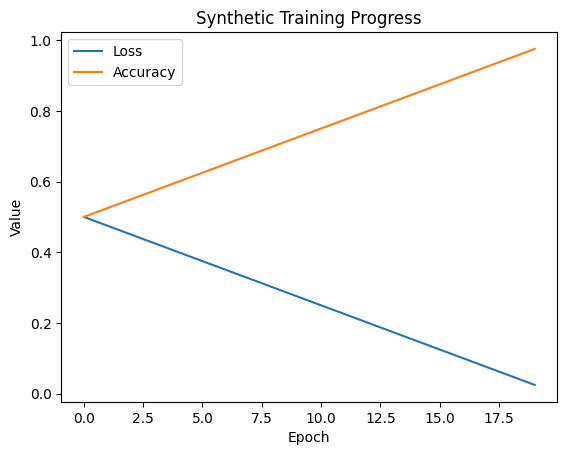

In [10]:
import matplotlib.pyplot as plt

# Generate synthetic training progress data (loss and accuracy)
epochs = list(range(args.epochs))
loss_values = [0.5 - (epoch / (2 * args.epochs)) for epoch in epochs]
accuracy_values = [0.5 + (epoch / (2 * args.epochs)) for epoch in epochs]

# Create line plots
plt.figure()
plt.plot(epochs, loss_values, label='Loss')
plt.plot(epochs, accuracy_values, label='Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Synthetic Training Progress')
plt.show()


<a id="section12"><font color='#FF6F00'><h2>Predict</h2></font></a>

- The `predict_from_dataset()` and `predict_from_text()` method is where we do our predictions/inference. Here we are using the texts in test set to generate our code in `predict_from_dataset()` but one can call `predict_from_text()` and provide custom input.

- `run_predict()` is the main function which calls `model.generate()` method to output the model predictions using decoding technique.

- In `predict_from_dataset()` we randomly choose an index from the test dataset, so everytime the function is called we randomly sample an index from the dataset.

- Notes:
    -  Here we are using Top-p (nucleus) sampling technique for decoding. In simple, top-p sampling chooses from the smallest possible set of words whose cumulative probability exceeds the probability p. The probability mass is then redistributed among this set of words. This way, the size of the set of words (a.k.a the number of words in the set) can dynamically increase and decrease according to the next word's probability distribution. Here we can use Top-p sampling by setting 0 < `top_p` < 1.

    - `Top-p` can also be used in combination with `Top-K`, which can avoid very low ranked words while allowing for some dynamic selection.

    - `Reptition_penalty` can be used to penalize words that were already generated or belong to the context.

    - To get multiple independently sampled outputs, we can again set the parameter `num_return_sequences` > 1.

In [11]:
def run_predict(args, text):
    # load saved finetuned model
    model = TFT5ForConditionalGeneration.from_pretrained(args.save_dir)
    # load saved tokenizer
    tokenizer = RobertaTokenizer.from_pretrained(args.save_dir)

     # encode texts by prepending the task for input sequence and appending the test sequence
    query = args.prefix + text
    encoded_text = tokenizer(query, return_tensors='tf', padding='max_length', truncation=True, max_length=args.max_input_length)

    # inference
    generated_code = model.generate(
        encoded_text["input_ids"], attention_mask=encoded_text["attention_mask"],
        max_length=args.max_target_length, top_p=0.95, top_k=50, repetition_penalty=2.0, num_return_sequences=1
    )

    # decode generated tokens
    decoded_code = tokenizer.decode(generated_code.numpy()[0], skip_special_tokens=True)
    return decoded_code

def predict_from_dataset(args):
    # load using hf datasets
    dataset = load_dataset('json', data_files='/content/mbpp.jsonl')
    # train test split
    dataset = dataset['train'].train_test_split(0.1, shuffle=False)
    test_dataset = dataset['test']

    # randomly select an index from the validation dataset
    index = random.randint(0, len(test_dataset))
    text = test_dataset[index]['text']
    code = test_dataset[index]['code']

    # run-predict on text
    decoded_code = run_predict(args, text)

    print("#" * 25); print("QUERY: ", text);
    print()
    print('#' * 25); print("ORIGINAL: "); print("\n", code);
    print()
    print('#' * 25); print("GENERATED: "); print("\n", decoded_code);

def predict_from_text(args, text):
    # run-predict on text
    decoded_code = run_predict(args, text)
    print("#" * 25); print("QUERY: ", text);
    print()
    print('#' * 25); print("GENERATED: "); print("\n", decoded_code);

<a id="section12a"><font color='#425066'><h3>Predict from Dataset</h3></font></a>

In [12]:
# example 1
predict_from_dataset(args)
# example 2
predict_from_dataset(args)
# example 3
predict_from_dataset(args)

FileNotFoundError: Unable to find '/content/mbpp.jsonl'

<a id="section12b"><font color='#425066'><h3>Predict from Text</h3></font></a>

In [ ]:
# example 1
predict_from_text(args, "Write a function to add two random numbers"); print()
# example 2
predict_from_text(args, "Write a function to find the frequency of items in a list"); print()
# example 3
predict_from_text(args, "Write a function to concatenate two dictionary"); print()

<a id="section13"><font color='#FF6F00'><h2>Ending Notes</h2></font></a>

- In this notebook we explore how we can finetune a model on *Text-to-Code Generation* task using TensorFlow, HuggingFace and MBPP dataset.
- The results aren't as amazing but that's because the model is t5-base and because the fine-tuning set is extremely small. Also, a quote from the paper says,
  > While inspecting the dataset, we observed that some questions used uncommon function signatures (such as passing in
a list and its length as two separate arguments to a function), lacked detail, were somewhat ambiguous (e.g., “Write a
python function to count the number of squares in a rectangle.”), or performed unexpected operations in a function
that were paired with the provided tests (e.g., casting a float to an int before returning it, with the test performing
integer comparisons). - *Program Synthesis with Large Language Models*

- The above script can be used to finetune T5 on any of the [CodeXGLUE](https://paperswithcode.com/dataset/codexglue) benchmark by microsoft. In CodeXGLUE we have language understanding tasks - clone defect detection & clone detection or generation tasks - code summarization, generation, translation, and refinement. To learn more check [here](https://microsoft.github.io/CodeXGLUE/) or [here](https://www.microsoft.com/en-us/research/blog/codexglue-a-benchmark-dataset-and-open-challenge-for-code-intelligence/)

An AI powered coding assistant can be used with three code intelligence capabilities:

1. *Text-to-code generation*: generate code based on the natural language description
2. *Code autocompletion*: complete the whole function of code given the target function name
3. *Code summarization*: generate the summary of a function in natural language description
    
For the first two functionalities, developers could simply type the natural language description or the function signature to specify their intents, and our AI coding assistant can generate or complete the target function for them. This helps to accelerate their implementation and also reduce their reliance on external resources. For code summarization, it can automatically summarize a function into code comments, which enables faster documentation and easier software maintenance.


<a id="section14"><font color='#FF6F00'><h2>References</h2></font></a>
An acknowledgement to sources who made this notebook possible,

- [CodeT5: Identifier-aware Unified Pre-trained Encoder-Decoder Models for Code Understanding and Generation.](https://arxiv.org/pdf/2109.00859.pdf)
- [CodeT5: Identifier-aware Unified Pre-trained Encoder-Decoder Models for Code Understanding and Generation Blog.](https://blog.salesforceairesearch.com/codet5/)
- [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/pdf/1910.10683)
- [Codebert: A pre-trained model for programming and natural languages.](https://arxiv.org/pdf/2002.08155.pdf)
- [CodeXGLUE: A Machine Learning Benchmark Dataset for Code Understanding and Generation.](https://arxiv.org/pdf/2102.04664.pdf)
- [Unified pre-training for program understanding and generation.](https://arxiv.org/pdf/2107.03374.pdf)
- [Evaluating large language models trained on code.](https://arxiv.org/pdf/2107.03374.pdf)
- [text-to-text-transfer-transformer](https://github.com/google-research/text-to-text-transfer-transformer/tree/main/t5)
- [TensorFlow Tutorials](https://www.tensorflow.org/tutorials)
- [TensorFlow Guide](https://www.tensorflow.org/tutorials)
- [HuggingFace Transformers Docs](https://huggingface.co/docs/transformers/index)
- [HuggingFace Transformers](https://github.com/huggingface/transformers)
- [How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate)
- [Guiding Text Generation with Constrained Beam Search in 🤗 Transformers](https://huggingface.co/blog/constrained-beam-search)
- [Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code](https://github.com/huggingface/transformers)
- [Speeding up Transformer w/ Optimization Strategies](https://www.kaggle.com/code/rhtsingh/speeding-up-transformer-w-optimization-strategies)
- [All The Ways You Can Compress Transformers](https://www.kaggle.com/code/rhtsingh/all-the-ways-you-can-compress-transformers)

<font color='#FF6F00'><h2>Thank You!</h2></font>